# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Обязательные требования:
- В объединённом датафрейме должны быть только те ключи, которые
есть во всех датафреймах.
- RANDOM_STATE = дата начала проекта (240423)
- test_size=0.25
- Минимум три модели (например: линейная регрессия, случайный лес,
кэтбуст)
- Подбор гиперпараметров хотя бы у одной модели
(автоматизированный).
- Выбор лучшей модели по метрике на кросс-валидации.
- Проверка качества лучшей модели на тестовой выборке (одной).
- Анализ важности факторов (shap)
- Метрика MAE<=6.8

## 1. Проведение обзора данных (EDA)

### Подготовка данных

#### Импорт необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (RandomizedSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

#### Чтение файлов и сохранение полученных данных в переменные

In [2]:
try:
    df_arc = pd.read_csv('data_arc_new.csv')
    df_bulk = pd.read_csv('data_bulk_new.csv')
    df_bulk_t = pd.read_csv('data_bulk_time_new.csv')
    df_gas = pd.read_csv('data_gas_new.csv')
    df_temp = pd.read_csv('data_temp_new.csv')
    df_wire = pd.read_csv('data_wire_new.csv')
    df_wire_t= pd.read_csv('data_wire_time_new.csv')
except:
    df_arc = pd.read_csv('/datasets/data_arc_new.csv')
    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_t = pd.read_csv('/datasets/data_bulk_time_new.csv')
    df_gas = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp = pd.read_csv('/datasets/data_temp_new.csv')
    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_t= pd.read_csv('/datasets/data_wire_time_new.csv')

#### Получение общей информации о таблицах

In [3]:
def openresearch(data):  # Функция вывода общей информации о таблицах
    print('Первые 5 строк датафрейма:')
    display(data.head())
    print('Общая информация: \n')
    display(data.info())
    print('Статистический анализ данных:')
    display(data.describe())

Данные об элетродах:

In [4]:
openresearch(df_arc)

Первые 5 строк датафрейма:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Статистический анализ данных:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Данные о подаче сыпучих материалов(объем):

In [5]:
openresearch(df_bulk)

Первые 5 строк датафрейма:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Статистический анализ данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Данные о подаче сыпучих материалов(время):

In [6]:
openresearch(df_bulk_t)

Первые 5 строк датафрейма:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Статистический анализ данных:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Данные о продувке сплава газом:

In [7]:
openresearch(df_gas)

Первые 5 строк датафрейма:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Статистический анализ данных:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Результаты измерения температуры:

In [8]:
openresearch(df_temp)

Первые 5 строк датафрейма:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Статистический анализ данных:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [9]:
df_temp['Температура'].unique()

array([1571., 1604., 1618., 1601., 1606., 1613., 1581., 1577., 1589.,
       1602., 1596., 1597., 1598., 1599., 1600., 1623., 1617., 1625.,
       1576., 1592., 1586., 1543., 1582., 1595., 1587., 1574., 1580.,
       1585., 1593., 1616., 1608., 1583., 1588., 1591., 1610., 1621.,
       1615., 1619., 1605., 1607., 1611., 1590., 1609., 1584., 1603.,
       1579., 1626., 1560., 1563., 1594., 1612., 1578., 1566., 1572.,
       1575., 1567., 1562., 1564., 1614., 1573., 1570., 1538., 1556.,
       1542., 1565., 1660., 1659., 1654., 1690., 1652., 1666., 1667.,
       1669., 1668., 1642., 1658., 1671., 1630., 1655., 1663., 1635.,
       1656., 1641., 1631., 1653., 1648., 1569., 1559., 1558., 1548.,
       1541., 1553., 1662., 1679., 1637., 1644., 1622., 1624., 1649.,
       1629., 1643., 1526., 1550., 1561., 1557., 1544., 1568., 1620.,
       1645., 1647., 1638., 1547., 1627., 1628., 1551., 1549., 1650.,
       1684., 1634., 1651., 1633., 1640., 1554., 1532., 1632., 1704.,
       1705., 1700.,

Данные о проволочных материалах(объем):

In [10]:
openresearch(df_wire)

Первые 5 строк датафрейма:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Статистический анализ данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Данные о проволочных материалах(время):

In [11]:
openresearch(df_wire_t)

Первые 5 строк датафрейма:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Статистический анализ данных:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


#### Корректировка наименований столбцов 

In [12]:
df_arc.columns = ['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность']

In [13]:
df_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [14]:
df_bulk_t.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [15]:
df_gas.columns = ['key', 'газ_1']

In [16]:
df_temp.columns = ['key', 'время_замера', 'температура']

In [17]:
df_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

In [18]:
df_wire_t.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

#### Выводы 
- Все данные загружены, проведен статистический анализ, названия столбцов изменены в соответствии со *snake case*. 
- В данных об электродах скорее всего имеется выброс в значении реактивной мощности; датасет без пропусков.
- В данных о результатах измерения температуры значение минимальной температуры аномально для значений плавления стали; Все значения температуры - целые, впоследствии заменим тип данных на целочисленный.
- В данных о подаче сыпучих материалов много пропусков, но впоследствии их можно заменить нулями; в данных о проволочных материалах - аналогично. Число ненулевых строк в датасетах df_bulk и df_bulk_t, df_wire и df_wire_t совпадает.\
Итог: данные пригодны для дальнейшего исследования и моделирования.

### Анализ данных

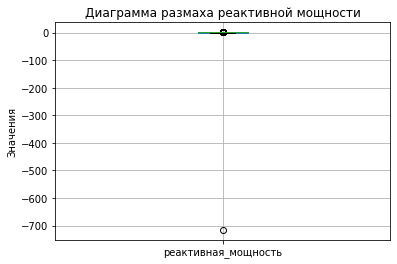

In [19]:
df_arc.boxplot('реактивная_мощность') 
plt.title('Диаграмма размаха реактивной мощности')
plt.ylabel('Значения');

In [20]:
df_arc = df_arc[df_arc['реактивная_мощность']>0]  # Удаляем аномальное значение реактивной мощности

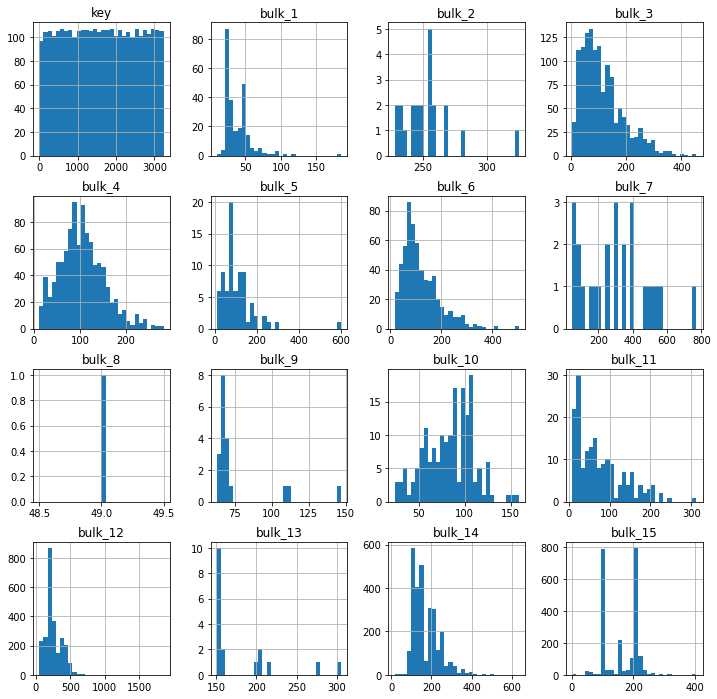

In [21]:
df_bulk.hist(figsize=(12,12), bins=30);

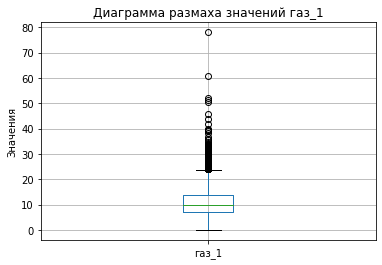

In [22]:
df_gas.boxplot('газ_1')
plt.title('Диаграмма размаха значений газ_1')
plt.ylabel('Значения');

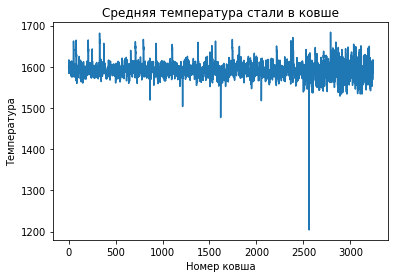

In [23]:
df_temp.groupby('key')['температура'].mean().plot()
plt.title('Средняя температура стали в ковше')
plt.xlabel('Номер ковша')
plt.ylabel('Температура');

In [24]:
df_temp = df_temp[df_temp['температура']>=1450]  # Удаляем все значения температуры ниже 1450°C

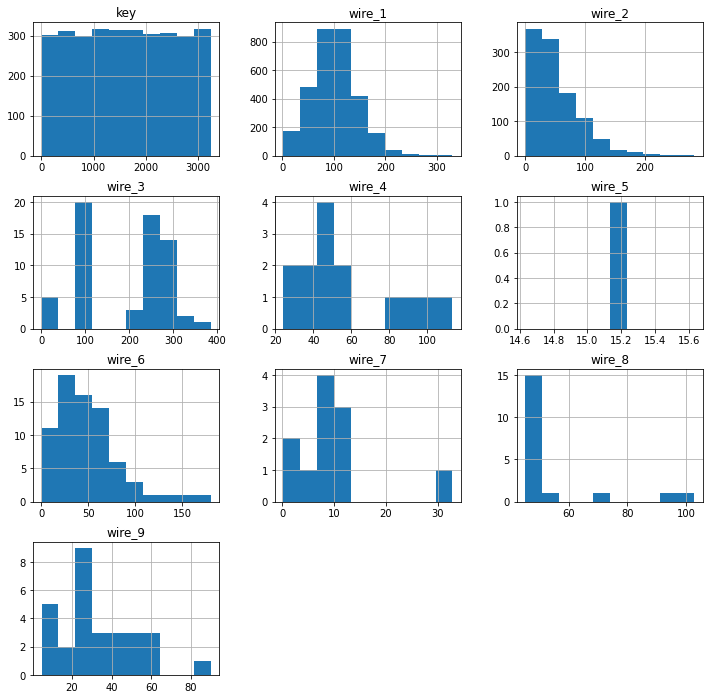

In [25]:
df_wire.hist(figsize=(12,12));

#### Выводы
- В данных реактивной мощности действительно был выброс, удалили его.
- В среднем, температура стали в каждом ковше держится в районе от 1500°C до 1700°C, есть аномальное значение в одном ковше- - 1191°C . Исходя из справочных данных(температура плавления стали 1450-1520°C) будем считать температуру ниже 1450°C  выбросом и удалим это значение. 
- Есть присадки, которые добавлялись в сплав чаще других, есть присадки, которые практически не добавлялись.

### Предобработка данных

#### Корректировка типов данных

In [26]:
df_temp['температура'] = df_temp['температура'].astype(int)

In [27]:
df_arc['начало_нагрева_дугой'] = pd.to_datetime(df_arc['начало_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['конец_нагрева_дугой'] = pd.to_datetime(df_arc['конец_нагрева_дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   начало_нагрева_дугой  14875 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14875 non-null  datetime64[ns]
 3   активная_мощность     14875 non-null  float64       
 4   реактивная_мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


#### Заполнение пропусков / проверка на наличие дубликатов

Отсутствие значений в присадках означает то, что их не добавляли. Поэтому, заменими все NAN на '0'.

In [28]:
df_bulk = df_bulk.fillna(0)
df_bulk_t = df_bulk_t.fillna(0)
df_wire = df_wire.fillna(0)
df_wire_t = df_wire_t.fillna(0)

print(df_bulk.isna().sum()) # Проверяем, все ли пропуски заполнились
print(df_bulk_t.isna().sum())
print(df_wire.isna().sum())
print(df_wire_t.isna().sum())

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64
key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64


In [29]:
list_df = [df_bulk, df_bulk_t, df_wire, df_wire_t, df_temp, df_arc, df_gas]
for df in list_df:
    print(df.duplicated().sum())

0
0
0
0
0
0
0


#### Выделение признаков и целевого признака

В качестве целевого признака выделим конечную температуру стали в каждом ковше. Также, на основе наших данных сгенерируем несколько дополнительных признаков: начальная температура плавления стали, полная мощность, потребляемая при нагреве стали дугой, время нагрева дугой. 

В данных есть ковши без конечной целевой температуры, например, ковш номер 3000:

In [30]:
df_temp[df_temp['key']==3000]

,key,время_замера,температура
16804,3000,2019-08-29 09:48:33,1609


Посмотрим, сколько таких ковшей присутствует в даных:

In [31]:
vc = df_temp['key'].value_counts()
vc

2108    17
1513    16
1689    16
46      14
322     14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3215, dtype: int64

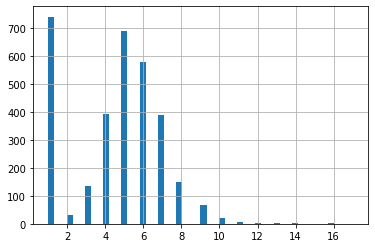

In [32]:
df_temp['key'].value_counts().hist(bins=50);

Достаточно мого ковшей без целевой температуры - более 700. Для адекватного обучения модели неообходимо избавиться от всех таких ковшей.

In [33]:
df_temp_2 = pd.DataFrame({'key':vc.index, 'count':vc.values})  # Создали датафрейм, чтобы затем найти срез по данным
df_temp_2

,key,count
0,2108,17
1,1513,16
2,1689,16
3,46,14
4,322,14
...,...,...
3210,3236,1
3211,2963,1
3212,2955,1
3213,2947,1


In [34]:
df_temp_2 = df_temp_2[df_temp_2['count']>1] 
df_temp_2

,key,count
0,2108,17
1,1513,16
2,1689,16
3,46,14
4,322,14
...,...,...
2470,2194,2
2471,1449,2
2472,530,2
2473,2112,2


In [35]:
df_temp_first = df_temp.groupby('key').head(1)
df_temp_first = df_temp_first[['key', 'температура']]
df_temp_first.columns = ['key', 'нач_температура']
df_temp_last = df_temp.groupby('key').tail(1)
df_temp_last = df_temp_last[['key', 'температура']]
df_temp_last.columns = ['key', 'целевая_температура']
display(df_temp_last)
df_temp_first

,key,целевая_температура
5,1,1613
10,2,1602
16,3,1599
21,4,1625
26,5,1602
...,...,...
18061,3237,1569
18067,3238,1584
18071,3239,1598
18080,3240,1617


,key,нач_температура
0,1,1571
6,2,1581
11,3,1596
17,4,1601
22,5,1576
...,...,...
18061,3237,1569
18067,3238,1584
18071,3239,1598
18080,3240,1617


В качестве дополнительного признака посчитаем время нагрева стали дугой:

In [36]:
df_arc['время_нагрева_дугой'] = (df_arc['конец_нагрева_дугой'] - df_arc['начало_нагрева_дугой']).dt.seconds
df_arc

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева_дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57


Также рассчитаем полную мощность, которая учитывает активную и реактивную составляющие.
Формула полной мощности:  $ S = \sqrt{P^2+Q^2} $. Добавим все результаты в таблицу.

In [37]:
df_arc['полная_мощность'] = ((df_arc['активная_мощность'])**2 + (df_arc['реактивная_мощность'])**2)**0.5
df_arc_total = df_arc.groupby('key')[['полная_мощность', 'время_нагрева_дугой']].sum()
display(df_arc)
df_arc_total

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева_дугой,полная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934
...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,0.641792


,полная_мощность,время_нагрева_дугой
key,,
1,3.718736,1098
2,2.588349,811
3,5.019223,655
4,3.400038,741
5,2.816980,869
...,...,...
3237,3.250657,909
3238,1.723937,546
3239,6.014480,1216


#### Объединение таблиц

Объединим все таблицы, за исключением таблиц времени. В нашей задаче время не влияет на целевой признак. Также добавим целевой признак, начальную температуру и подсчитанные полную мощность и время нагрева дугой.

In [38]:
df = pd.merge(df_arc_total, df_bulk, on='key', how='inner')
df = df.merge(df_gas, on='key', how='inner')
df = df.merge(df_wire, on='key', how='inner')
df = df.merge(df_temp_first, on='key', how='inner')
df = df.merge(df_temp_last, on='key', how='inner')
df = df.merge(df_temp_2, on='key', how='inner')

In [39]:
pd.set_option('display.max_columns', None)
df

,key,полная_мощность,время_нагрева_дугой,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,газ_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,нач_температура,целевая_температура,count
0,1,3.718736,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571,1613,6
1,2,2.588349,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581,1602,5
2,3,5.019223,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596,1599,6
3,4,3.400038,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601,1625,5
4,5,2.816980,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576,1602,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,3.868721,723,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570,1591,5
2325,2496,5.070316,940,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554,1591,7
2326,2497,4.360918,569,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571,1589,4
2327,2498,3.909917,750,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591,1594,6


In [41]:
features = df.drop(['целевая_температура', 'key', 'count'], axis=1)  # Выделили признаки
target = df['целевая_температура']  # Выделили целевой признак

#### Выводы

- Тип данных по температуре в таблице df_temp изменен на целочисленный, изменены типы столбцов 'начало_нагрева_дугой', 'конец_нагрева_дугой' с object на datetime для использования данных столбцов в дальнейших расчетах.
- В качестве целевого принака выделена конечная температура нагрева стали в каждом ковше.
- Удалены все ковши без целевой температуры,
- Все данные, за исключением времени замера температур, объединены в итоговую таблицу. Также, в итоговую таблицу добавились столбцы 'полная_мощность' и 'время_нагрева_дугой'.

### Исследование итоговой таблицы с данными

Так как в наших данных все признаки - числовые, для исследования корреляции можем воспользоваться коэффициентом корреляции Пирсона.

CPU times: user 530 ms, sys: 113 ms, total: 643 ms
Wall time: 618 ms


<AxesSubplot:>

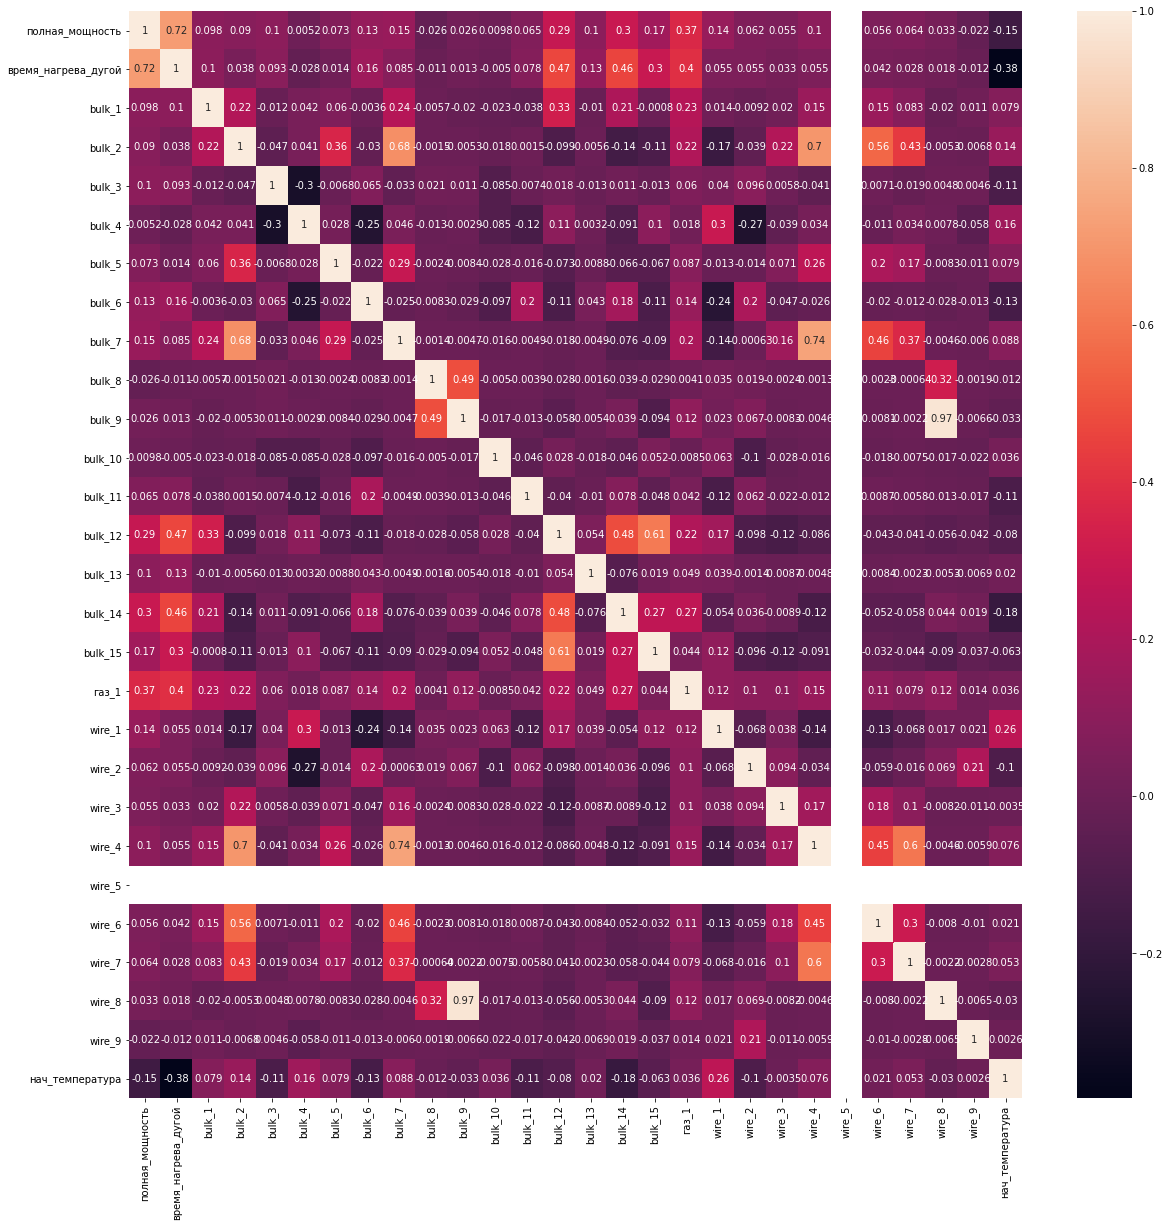

In [42]:
%%time
coor_matrix = features.corr()  
plt.figure(figsize=(20,20))
sns.heatmap(coor_matrix, annot=True);

Из матрицы корреляции следует:
- между собой сильно коррелируют признаки 'bulk_9' и 'wire_8', 'bulk_7' и 'bulk_2', а также 'bulk_7' и 'wire_4', 'bulk_12' и 'bulk_15'. Также, признаки 'полная_мощность' и 'время_нагрева_дугой' имеют сильную зависимость,
- столбец 'wire_5' остался пустым, удалим его.

In [43]:
features = features.drop(['wire_5'], axis=1)

Признаки с высокой корреляцией негативно влияют на модель линейной регрессии, удалим часть из них перед обучением модели.

#### Выводы

В результате исследования итоговой таблицы с данными:
- выявлены признаки, сильно коррелирующие друг с другом,
- удален пустой столбец 'wire_5'.

## 2. Построение моделей машинного обучения

### Обучение моделей

In [44]:
RANDOM_STATE = 240423

In [45]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)


In [46]:
print('Размер тренировочной признаковой выборки:', features_train.shape)
print('Размер тренировочной целевой выборки:', features_test.shape)
print('Размер тестовой признаковой выборки:', target_train.shape)
print('Размер тестовой целевой выборки:', target_test.shape)

Размер тренировочной признаковой выборки: (1746, 27)
Размер тренировочной целевой выборки: (583, 27)
Размер тестовой признаковой выборки: (1746,)
Размер тестовой целевой выборки: (583,)


In [47]:
features_train

,полная_мощность,время_нагрева_дугой,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,газ_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,нач_температура
1524,1.398344,261,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.834714,103.568398,44.063759,0.000000,0.0,0.0,0.0,0.0,0.0,1610
1223,3.739797,677,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.042956,152.099991,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1576
376,5.492642,706,0.0,0.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,128.0,218.0,14.244007,181.350006,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1598
363,3.317154,973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,256.0,0.0,16.194449,129.261596,108.515679,279.783508,0.0,0.0,0.0,0.0,0.0,1554
444,3.290917,486,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,0.0,168.0,205.0,7.093691,92.149200,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,7.182999,1170,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,105.0,206.0,22.911746,137.919601,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1629
1682,1.848078,595,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,88.0,0.0,253.0,0.0,119.0,204.0,4.340270,39.077999,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1583
1365,4.632762,896,0.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,0.0,0.0,11.599899,137.077194,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1576
1,2.588349,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1581


#### Линейная регрессия

Удалим из тренировочной и тестовой выборок сильно коррелирующие признаки.

In [48]:
features_train_lr = features_train.drop(
    ['bulk_7', 'bulk_2', 'bulk_15', 'bulk_9', 'bulk_8', 'wire_7', 'полная_мощность'], axis=1
)
features_test_lr = features_test.drop(
    ['bulk_7', 'bulk_2', 'bulk_15', 'bulk_9', 'bulk_8', 'wire_7', 'полная_мощность'], axis=1
)

CPU times: user 271 ms, sys: 120 ms, total: 391 ms
Wall time: 383 ms


<AxesSubplot:>

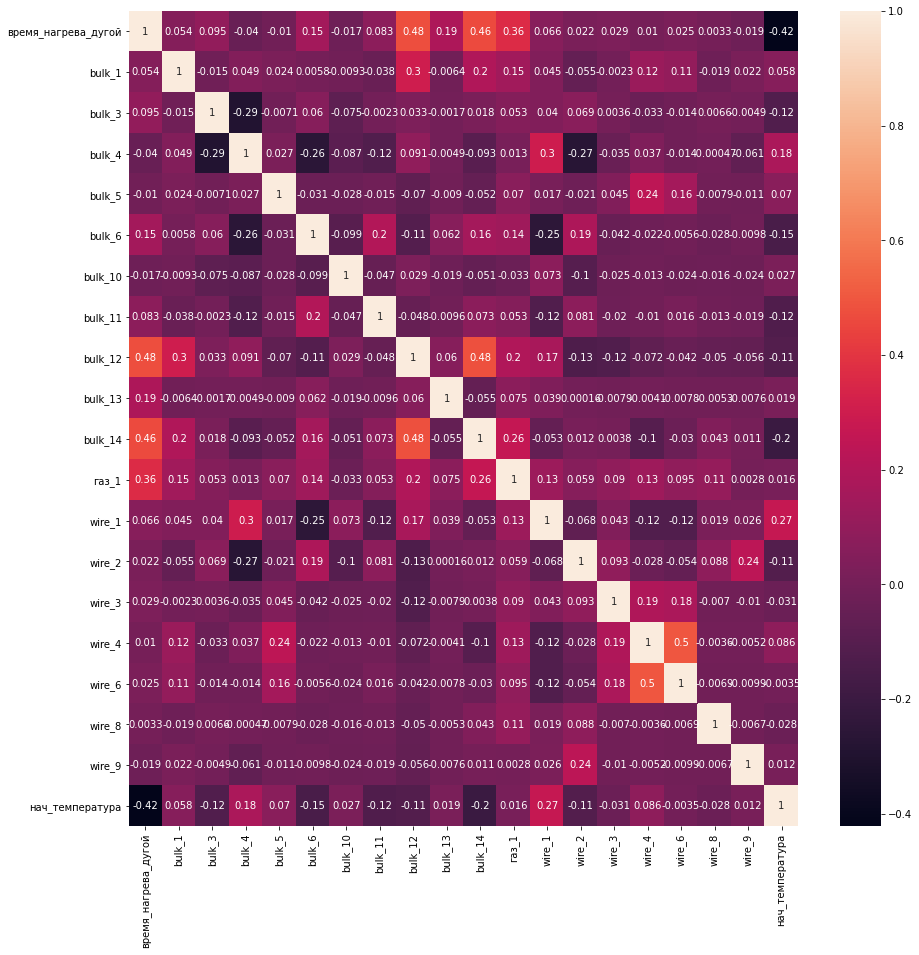

In [49]:
%%time
coor_matrix = features_train_lr.corr()  
plt.figure(figsize=(15,15))
sns.heatmap(coor_matrix, annot=True);

In [50]:
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

In [51]:
linear_score = cross_val_score(
    linear_pipe, features_train_lr, target_train, scoring = 'neg_mean_absolute_error', cv=5
).mean()

In [52]:
print('MAE модели:', round(linear_score*(-1),3))

MAE модели: 6.209


#### RandomForestRegressor (Случайный лес)

In [52]:
%%time
rf_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor())])
param_dist = {
    'regressor__n_estimators': [x for x in range(50, 501, 50)],
    'regressor__max_depth':[3, 5, 10, None],
    'regressor__random_state': [RANDOM_STATE]
             }
search = RandomizedSearchCV(rf_pipe, 
                        param_dist,
                        n_jobs=-1,
                        scoring='neg_mean_absolute_error',
                        cv = 5,
                        random_state=RANDOM_STATE
                       )
search.fit(features_train, target_train)
print(search.best_params_)
print('Лучшая метрика MAE модели:', round(search.best_score_,3)*(-1))

{'regressor__random_state': 240423, 'regressor__n_estimators': 400, 'regressor__max_depth': 10}
Лучшая метрика MAE модели: 6.192
CPU times: total: 3.52 s
Wall time: 24 s


#### XGBRegressor,  LGBMRegressor,  CatBoostRegressor

In [53]:
%%time
regressors = [XGBRegressor, LGBMRegressor, CatBoostRegressor]
for regressor in regressors:
    reg_pipe =  Pipeline(
        [('scaler', StandardScaler()), ('regressor', regressor(random_state=RANDOM_STATE, verbose=100))]
    )
    param_dist = {
        'regressor__n_estimators': [x for x in range(500, 1500, 50)],
        'regressor__random_state': [RANDOM_STATE]
                 }
    search_reg = RandomizedSearchCV(reg_pipe, 
                            param_dist,
                            n_jobs=-1,
                            scoring='neg_mean_absolute_error',
                            cv = 5,  
                            random_state=RANDOM_STATE
                           )
    search_reg.fit(features_train, target_train)
    print(regressor)
    print('Лучшая метрика MAE модели:', round(search_reg.best_score_,3)*(-1))

[14:37:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

<class 'xgboost.sklearn.XGBRegressor'>
Лучшая метрика MAE модели: 6.646
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.942798
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.396968
[LightGBM] [Debug] init for col-wise cost 0.001053 seconds, init for row-wise cost 0.000806 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 1746, number of used features: 19
[LightGBM] [Info] Start training from score 1593.359679
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth =

#### Константная модель

In [54]:
dummy = DummyRegressor(strategy='median')
dummy.fit(features_train, target_train)   
predict = dummy.predict(features_test)   
MAE_dummy = mean_absolute_error(target_test, predict)   
print('MAE:', round(MAE_dummy, 3))

MAE: 8.424


#### Выбор лучшей модели

Метрика MAE на тренировочной выборке для трех обученных моделей:
- Линейная регрессия: 6.209
- RandomForestRegressor(Случайный лес): 6.192
- XGBRegressor: 6.646
- LGBMRegressor: 6.552
- CatBoostRegressor: 6.088
- Константная модель: 8.424

**Вывод.**  За лучшую модель примем модель  CatBoostRegressor, показавшую лучшую метрику MAE на тренировочной выборке.

### Тестирование лучшей модели

In [55]:
search_reg.best_estimator_
search_reg.best_params_

{'regressor__random_state': 240423, 'regressor__n_estimators': 750}

In [56]:
pred = search_reg.best_estimator_.predict(features_test)
test_score = mean_absolute_error(target_test, pred)
print('тестовая MAE:', round(test_score, 3))

тестовая MAE: 6.469


### Анализ важности признаков

In [57]:
def importance(model):  # Функция построения графика важности признаков
    imp = pd.Series(
        model.best_estimator_.steps[1][1].feature_importances_[np.argsort(
            model.best_estimator_.steps[1][1].feature_importances_
        )], features_train.columns[np.argsort
                                   (model.best_estimator_.steps[1][1].feature_importances_)
                                  ])
    fig, ax = plt.subplots(figsize=(8, 6))
    imp.plot.bar(ax=ax)
    plt.xticks(rotation=45)
    ax.set_title("Важность признаков")
    ax.set_ylabel('Важность')
    fig.tight_layout()

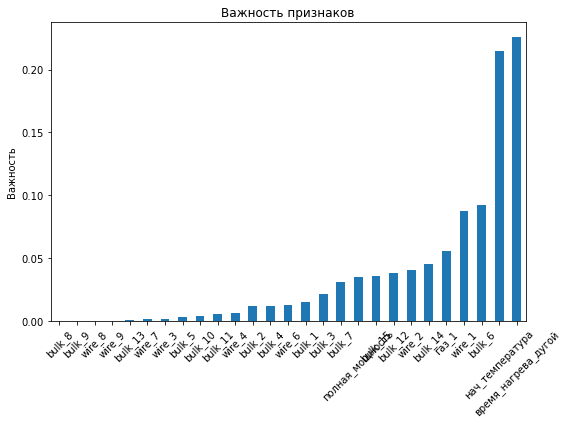

In [58]:
importance(search)

## Общий вывод

- В результате исследования был проведен анализ производственного процесса, анализ полученных данных, затем была решена задача регрессии для предсказания температуры стали.
- В процессе анализа данных были выявлены и удалены аномальные значения, из всех данных получена объединенная таблица, выделены признаки и целевой признак. Также, были сгенерированы дополнительные признаки для улучшения обучения модели.
- Обучающие признаки проверены на корреляцию, масштабированы.
- Обучены модели: 'Линейная регрессия', RandomForestRegressor('Случайный лес'), 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor'. Для всех моделей, кроме линейной регрессии, был проведен автоматический поиск гиперпараметров. Наилучшую метрику на тренировочной выборке показала модель 'CatBoostRegressor'.
- Метрика MAE наилучшей модели на тестовой выборке удовлетворяет поставленному условию.
- Из анализа важности признаков следует, что сгенерированный признак 'время_нагрева_дугой' сильно повлиял на предсказания; также, 'начальная температура' является важным признаком при обучении модели. 
- Модель 'CatBoostRegressor' прошла проверку на адекватность, показав метрику лучше, чем константная модель, предсказывающая медианный результат.